# Imports

In [1]:
# ALL
import cv2
import math
import os
import PIL
import sys

# AS
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# FROM
from osgeo import gdal
from PIL import Image, ImageOps, ImageChops, ImageDraw, ImageFont
from skimage import exposure
from tabulate import tabulate

# Data Preperation

In [2]:
# Set the working directory
base_dir = "/Users/izzymohamed/Desktop/Vision For Social Good/Exclude/DATA/Peach"

### Step 1: Load and Process Tree Mapping Data

In [3]:
# Load the Tree Mapping Excel file
tree_mapping_path = os.path.join(base_dir, "Tree Mapping.xlsx")
tree_mapping_excel_file = pd.ExcelFile(tree_mapping_path)

# Load the Tree Mapping Excel file into a DataFrame
tree_mapping_df = pd.read_excel(tree_mapping_path, header=None)

# Load each sheet in the Excel file into its own DataFrame
tree_mapping_dfs = {sheet: pd.read_excel(tree_mapping_excel_file, sheet_name=sheet) for sheet in tree_mapping_excel_file.sheet_names}

In [4]:
# Display the first few rows of the dataframe to understand its structure
tree_mapping_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,3.0,3.0,3.0,3.0,3,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,4.0,4.0,4.0,4.0,4,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,5.0,5.0,5.0,5.0,5,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,5.0


In [5]:
# Display the first few rows of each DataFrame to understand its structure
for sheet, df in tree_mapping_dfs.items():
    print(f"Sheet name: {sheet}")
    print(tabulate(df.head(), headers='keys', tablefmt='pretty'))
    print("\n")

Sheet name: 27_07_21
+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|   |  1  | 1.1 | 1.2 | 1.3 | 1.4 | 1.5 | 1.6 | 1.7 | 1.8 | 1.9 | 1.10 | 1.11 | 1.12 | 1.13 | 1.14 | 1.15 | 1.16 | 1.17 | 1.18 | 1.19 | 1.20 | 1.21 | 1.22 | 1.23 | 1.24 | 1.25 | 1.26 | 1.27 | 1.28 | 1.29 |
+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
| 0 | 2.0 | 2.0 | 2.0 | 2.0 |  2  | 2.0 | 2.0 | 2.0 | 2.0 | 2.0 | 2.0  |  2   |  2   |  2   |  2   |  2   |  2   |  2   |  2   |  2   | 2.0  | 2.0  | 2.0  | 2.0  | 2.0  | 2.0  | 2.0  | 2.0  | 2.0  | 2.0  |
| 1 | 3.0 | 3.0 | 3.0 | 3.0 |  3  | 3.0 | 3.0 | 3.0 | 3.0 | 3.0 | 3.0  |  3   |  3   |  3   |  3   |  3   |  3   |  3   |  3   |  3   | 3.0  | 3.0  | 3.0  

In [6]:
# Load the Label Excel file
label_path = os.path.join(base_dir, "04_11_21", "04_11_21.csv")
label_df = pd.read_csv(label_path, header=None,names=['Tree_ID', 'Label'])

# Display the first few rows of the dataframe to understand its structure
label_df.head()

,Tree_ID,Label
0,1-1,0
1,1-2,0
2,1-3,0
3,1-4,0
4,1-5,0


### Step 2: Load Image Metadata

In [7]:
# Define directories for the images
uav_dir = os.path.join(base_dir, "04_11_21", "Aerial_UAV_Photos")
rgb_dir = os.path.join(base_dir, "04_11_21", "Ground_RGB_Photos")
multispectral_dir = os.path.join(base_dir, "04_11_21", "Ground_Multispectral_Photos")

In [8]:
# Load the provided NDVI images
ndvi_data_path = os.path.join(uav_dir, "NDVI.data.tif") #"/mnt/data/NDVI.data.jpeg"
ndvi_rgb_path = os.path.join(uav_dir, "NDVI.rgb.tif") #"/mnt/data/NDVI.rgb.jpeg"

# Load the NDVI images using OpenCV
ndvi_data_image = cv2.imread(ndvi_data_path, cv2.IMREAD_UNCHANGED)
ndvi_rgb_image = cv2.imread(ndvi_rgb_path, cv2.IMREAD_UNCHANGED)

In [9]:
# Show sample structure of the directories in depth
def list_directories(path, current_depth=0):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.TIF'}
    try:
        entries = os.listdir(path)
    except PermissionError:
        return

    for entry in entries:
        full_path = os.path.join(path, entry)
        if os.path.isdir(full_path):
            print(f"{' ' * (current_depth * 2)}{entry}/")
            list_directories(full_path, current_depth + 1)
        else:
            _, ext = os.path.splitext(entry)
            if ext.lower() in image_extensions:
                print(f"{' ' * (current_depth * 2)}{entry} (image file)")
                return
            else:
                print(f"{' ' * (current_depth * 2)}{entry}")

In [10]:
# Display the first 2 levels of the directories
print("UAV Directory:")
list_directories(uav_dir)
print("\nRGB Directory:")
list_directories(rgb_dir)
print("\nMultispectral Directory:")
list_directories(multispectral_dir)

UAV Directory:
NDVI_RGB.png (image file)

RGB Directory:
.DS_Store
Healthy/
  25-15.jpg (image file)
Dead Trees/
  3-26.jpg (image file)
Grapholita molesta/
  6-29.jpg (image file)
Anarsia lineatella/
  4-13.jpg (image file)

Multispectral Directory:
.DS_Store
Healthy/
  10 - 30/
    sequoia_diag.dat
    IMG_700101_001934_0000_RGB.JPG (image file)
  7 - 2/
    sequoia_diag.dat
    IMG_700101_000116_0000_RGB.JPG (image file)
  17 - 25/
    IMG_700101_001822_0000_REG.TIF
    IMG_700101_001822_0000_RED.TIF
    sequoia_diag.dat
    IMG_700101_001822_0000_GRE.TIF
    IMG_700101_001822_0000_NIR.TIF
    IMG_700101_001822_0000_RGB.JPG (image file)
  13 - 20/
    IMG_700101_004307_0000_RGB.JPG (image file)
  17 - 22/
    sequoia_diag.dat
    IMG_700101_001750_0000_RGB.JPG (image file)
  7 - 5/
    sequoia_diag.dat
    IMG_700101_000146_0000_NIR.TIF
    IMG_700101_000146_0000_REG.TIF
    IMG_700101_000146_0000_RED.TIF
    IMG_700101_000146_0000_GRE.TIF
    sequoia_param.dat
    IMG_700101_000146

In [11]:
# Function to load image filenames
def load_image_filenames(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.tif', '.TIF')):
                file_list.append(os.path.join(root, file))
    return file_list

In [12]:
# Load the image filenames
uav_images = load_image_filenames(uav_dir)
rgb_images = load_image_filenames(rgb_dir)
# multispectral_images = load_image_filenames(multispectral_dir)

In [13]:
# Display the number of images in each category
print(f"UAV images: {len(uav_images)}")
print(f"RGB images: {len(rgb_images)}")
# print(f"Multispectral images: {len(multispectral_images)}")

UAV images: 13
RGB images: 887


In [14]:
# Function to load specific multispectral image filenames (IMG_700101_XXXXXX_XXXX_RGB.JPG)
def load_multispectral_filenames(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith('IMG_') and file.endswith('_RGB.JPG'):
                file_list.append(os.path.join(root, file))
    return file_list

In [15]:
# Display the multispectral images
multispectral_images = load_multispectral_filenames(multispectral_dir)
print(f"Multispectral images: {len(multispectral_images)}")

Multispectral images: 885


### Step 3: Link Images Using Tree Mapping

In [16]:
# Function to extract tree ID from filename
def extract_tree_id(filename):
    base_name = os.path.basename(filename)
    parts = base_name.split('_')
    
    # Check if filename follows '3-26.jpg' pattern
    if '-' in base_name:
        return base_name.split('.')[0]
    # Check if filename follows 'IMG_700101_000146_0000_RGB.JPG' pattern
    elif len(parts) >= 3:
        # Extract tree ID from the directory structure, assuming the pattern is '7 - 2/IMG_700101_000116_0000_RGB.JPG'
        parent_dir = os.path.basename(os.path.dirname(filename))
        if ' - ' in parent_dir:
            return parent_dir.replace(' ', '')
        return parts[1] + '-' + parts[2]
    else:
        return None  # Return None if the pattern does not match

In [17]:
# Create dictionaries to link images to tree IDs
# uav_dict = {extract_tree_id(img): img for img in uav_images if extract_tree_id(img) is not None}
rgb_dict = {extract_tree_id(img): img for img in rgb_images if extract_tree_id(img) is not None}
multispectral_dict = {extract_tree_id(img): img for img in multispectral_images if extract_tree_id(img) is not None}

In [18]:
# Example linking for a specific tree ID
tree_id = '3-26'
uav_image = os.path.join(uav_dir, "NDVI.rgb.tif")
rgb_image = rgb_dict.get(tree_id)
multispectral_image = multispectral_dict.get(tree_id)

print(f"Tree {tree_id}:")
print(f"        UAV: {uav_image}")
print(f"        RGB: {rgb_image}")
print(f"        Multispectral {multispectral_image}")

Tree 3-26:
        UAV: /Users/izzymohamed/Desktop/Vision For Social Good/Exclude/DATA/Peach/04_11_21/Aerial_UAV_Photos/NDVI.rgb.tif
        RGB: /Users/izzymohamed/Desktop/Vision For Social Good/Exclude/DATA/Peach/04_11_21/Ground_RGB_Photos/Dead Trees/3-26.jpg
        Multispectral /Users/izzymohamed/Desktop/Vision For Social Good/Exclude/DATA/Peach/04_11_21/Ground_Multispectral_Photos/Dead Trees/3 - 26/IMG_700101_002106_0000_RGB.JPG


### Step 5: 

In [19]:
# Define the health status colors
status_colors = {
    0: 'green',   # Healthy
    1: 'blue',    # Grapholita molesta
    2: 'red',     # Anarsia lineatella
    3: 'black'    # Dead Trees
}

In [20]:
# Define a function to create a status grid from the CSV data
def create_status_grid(df):
    max_row = 0
    max_col = 0
    status_dict = {}
    
    for index, row in df.iterrows():
        tree_id, status = row[0], row[1]
        row_idx, col_idx = map(int, tree_id.split('-'))
        status_dict[(row_idx, col_idx)] = status
        max_row = max(max_row, row_idx)
        max_col = max(max_col, col_idx)
    
    status_grid = np.full((max_row, max_col), np.nan)
    for (row_idx, col_idx), status in status_dict.items():
        status_grid[row_idx-1, col_idx-1] = status
    
    return status_grid

In [21]:
# Create the status grid from the CSV data
status_grid = create_status_grid(label_df)

/var/folders/qd/ds8njzhn1zv9q727vvvr8h0m0000gn/T/ipykernel_97098/2017960110.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tree_id, status = row[0], row[1]


In [22]:
# Define a function to plot the orchard mapping from the status grid
def plot_orchard_from_grid(status_grid, title, output_folder):
    fig, ax = plt.subplots(figsize=(12, 12))
    for i in range(status_grid.shape[0]):
        for j in range(status_grid.shape[1]):
            status = status_grid[i, j]
            if not np.isnan(status):
                color = status_colors.get(int(status), 'gray')
                circle = plt.Circle((j, -i), 0.4, color=color, edgecolor='black')
                ax.add_patch(circle)
    ax.set_xlim(-1, status_grid.shape[1])
    ax.set_ylim(-status_grid.shape[0], 1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(output_folder, f"{title}.png"))
    plt.show()

In [23]:
# Define a function to save the orchard plot without any colors
def plot_orchard_no_color(df, title, filename):
    fig, ax = plt.subplots(figsize=(12, 12))
    for i, row in df.iterrows():
        for j, status in enumerate(row):
            try:
                status = float(status)
                if not np.isnan(status):
                    circle = plt.Circle((j, -i), 0.4, edgecolor='black', facecolor='none')
                    ax.add_patch(circle)
            except ValueError:
                pass
    ax.set_xlim(-1, df.shape[1])
    ax.set_ylim(-df.shape[0], 1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.gca().invert_yaxis()
    plt.savefig(filename)
    plt.close()

In [24]:
# Define the annotation file path
annotation_file_path = os.path.join(base_dir, '04_11_21', 'Orchard_Mapping') # '/mnt/data/tree_annotations.txt'

/var/folders/qd/ds8njzhn1zv9q727vvvr8h0m0000gn/T/ipykernel_97098/2290415208.py:9: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((j, -i), 0.4, color=color, edgecolor='black')


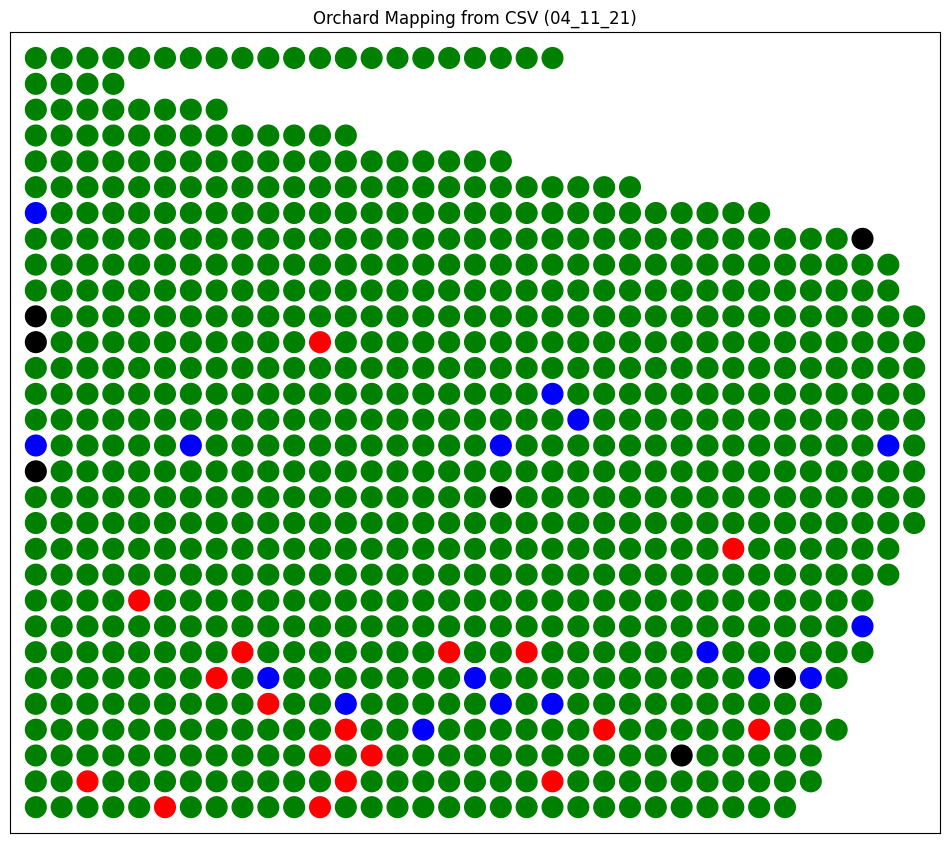

In [25]:
# Plot the orchard mapping for the status grid from the CSV data
plot_orchard_from_grid(status_grid, 'Orchard Mapping from CSV (04_11_21)', annotation_file_path)

In [26]:
# Create annotation file for image classification from the CSV data
def create_classification_annotations(df, output_folder, image_size):

    # Define the circle radius
    circle_radius = 0.4

    # Ensure that the provided path is treated as a file path
    txt_filename = os.path.join(output_folder, 'tree_annotations.txt')
    csv_filename = os.path.join(output_folder, 'tree_annotations.csv')
    
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create the annotation file
    with open(txt_filename, 'w') as file:
        annotations = []
        for index, row in df.iterrows():
            tree_id = row['Tree_ID']
            label = int(row['Label'])
            row_idx, col_idx = map(int, tree_id.split('-'))
            # Calculate the center of the circle for each tree
            center_x = col_idx
            center_y = row_idx
            # Convert to normalized coordinates (0 to 1)
            norm_center_x = center_x / image_size[0]
            norm_center_y = center_y / image_size[1]
            norm_radius = circle_radius / image_size[0]  # assuming square image, same scaling factor
            # Write the annotation in YOLO format: <tree_id> <label> <x_center> <y_center> <width> <height>
            annotation = f"{tree_id} {label} {norm_center_x} {norm_center_y} {norm_radius} {norm_radius}\n"
            file.write(annotation)
            # Collect the annotation data for CSV
            annotations.append([tree_id, label, norm_center_x, norm_center_y, norm_radius, norm_radius])

    # Create the annotation CSV file
    annotations_df = pd.DataFrame(annotations, columns=['Tree_ID', 'Label', 'Norm_Center_X', 'Norm_Center_Y', 'Norm_Radius_X', 'Norm_Radius_Y'])
    annotations_df.to_csv(csv_filename, index=False)

In [27]:
# Define the size of the image (number of columns and rows in the grid)
image_size = (status_grid.shape[1], status_grid.shape[0])  # (width, height)

In [28]:
# Create the annotation file for image classification
create_classification_annotations(label_df, annotation_file_path, image_size)

### Step 4: Create a Multimodal Dataset

In [29]:
# Define the paths to the annotation files
orchard_mapping_annotation_csv_path = os.path.join(annotation_file_path, 'tree_annotations.csv') # '/mnt/data/Orchard_Mapping/tree_annotations.csv'
orchard_mapping_image_path = os.path.join(annotation_file_path, 'Orchard Mapping from CSV (04_11_21).png') # '/mnt/data/Orchard_Mapping/Orchard Mapping from CSV (04_11_21).png'

In [30]:
# Read the annotation CSV file to get normalized coordinates and radius
orchard_mapping_annotation_df = pd.read_csv(orchard_mapping_annotation_csv_path)

In [31]:
# Create a DataFrame to store the multimodal dataset
data = []
for row_index, row in label_df.iterrows():
    tree_id = row['Tree_ID']
    label = row['Label']
    
    # Retrieve the normalized coordinates and radius
    annotation = orchard_mapping_annotation_df[orchard_mapping_annotation_df['Tree_ID'] == tree_id]
    if not annotation.empty:
        norm_center_x = annotation['Norm_Center_X'].values[0]
        norm_center_y = annotation['Norm_Center_Y'].values[0]
        norm_radius_x = annotation['Norm_Radius_X'].values[0]
        norm_radius_y = annotation['Norm_Radius_Y'].values[0]
    else:
        norm_center_x = norm_center_y = norm_radius_x = norm_radius_y = None
    
    # Assuming we have dictionaries for image paths (you can replace these with your actual dictionaries)
    rgb_image = rgb_dict.get(tree_id, None)
    multispectral_image = multispectral_dict.get(tree_id, None)
    uav_image = uav_image # uav_image_dict.get(tree_id, None)  # Assuming UAV image paths are stored similarly
    orchard_mapping_image = orchard_mapping_image_path
    
    data.append([tree_id, orchard_mapping_image, norm_center_x, norm_center_y, norm_radius_x, norm_radius_y, uav_image, rgb_image, multispectral_image, label])

In [32]:
# Create the multimodal DataFrame
multimodal_df = pd.DataFrame(data, columns=['Tree_ID', 'Orchard_Mapping_Image', 'Norm_Center_X', 'Norm_Center_Y', 'Norm_Radius_X', 'Norm_Radius_Y', 'UAV_Image', 'RGB_Image', 'Multispectral_Image', 'Label'])

In [33]:
# Display the first few rows of the DataFrame
multimodal_df.head()

,Tree_ID,Orchard_Mapping_Image,Norm_Center_X,Norm_Center_Y,Norm_Radius_X,Norm_Radius_Y,UAV_Image,RGB_Image,Multispectral_Image,Label
0,1-1,/Users/izzymohamed/Desktop/Vision For Social G...,0.028571,0.033333,0.011429,0.011429,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,0
1,1-2,/Users/izzymohamed/Desktop/Vision For Social G...,0.057143,0.033333,0.011429,0.011429,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,0
2,1-3,/Users/izzymohamed/Desktop/Vision For Social G...,0.085714,0.033333,0.011429,0.011429,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,0
3,1-4,/Users/izzymohamed/Desktop/Vision For Social G...,0.114286,0.033333,0.011429,0.011429,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,0
4,1-5,/Users/izzymohamed/Desktop/Vision For Social G...,0.142857,0.033333,0.011429,0.011429,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,/Users/izzymohamed/Desktop/Vision For Social G...,0


### Step 6: Checking Location

In [40]:
# Paths to the uploaded image files
uav_images_file_paths = {
    "green": os.path.join(uav_dir, 'green.data.tif'), 
    "green_rgb": os.path.join(uav_dir, 'green.rgb.tif'), 
    "ndvi": os.path.join(uav_dir, 'NDVI.data.tif'), 
    "ndvi_rgb": os.path.join(uav_dir, 'NDVI.rgb.tif'), 
    "nir": os.path.join(uav_dir, 'nir.data.tif'), 
    "nir_rgb": os.path.join(uav_dir, 'nir.rgb.tif'), 
    "red": os.path.join(uav_dir, 'red.data.tif'), 
    "red_rgb": os.path.join(uav_dir, 'red.rgb.tif'), 
    "rededge": os.path.join(uav_dir, 'rededge.data.tif'), 
    "rededge_rgb": os.path.join(uav_dir, 'rededge.rgb.tif'),
    # "orthomosaic_data": os.path.join(uav_dir, 'Orthomosaic.data.tif'),
    "orthomosaic_rgb": os.path.join(uav_dir, 'Orthomosaic.rgb.tif'),
    "orthomosaic": os.path.join(uav_dir, 'Orthomosaic.tif')
}

In [41]:
# Load and inspect images
uav_images = {}
for name, path in uav_images_file_paths.items():
    image = Image.open(path)
    # print(f"{name} - Mode: {image.mode}, Size: {image.size}, Format: {image.format}")
    uav_images[name] = image

In [42]:
# Convert images to RGB if necessary
converted_uav_images = {}
for name, image in uav_images.items():
    # if image.mode != 'RGB':
    #     image = image.convert('RGB')
    converted_uav_images[name] = np.asarray(image)

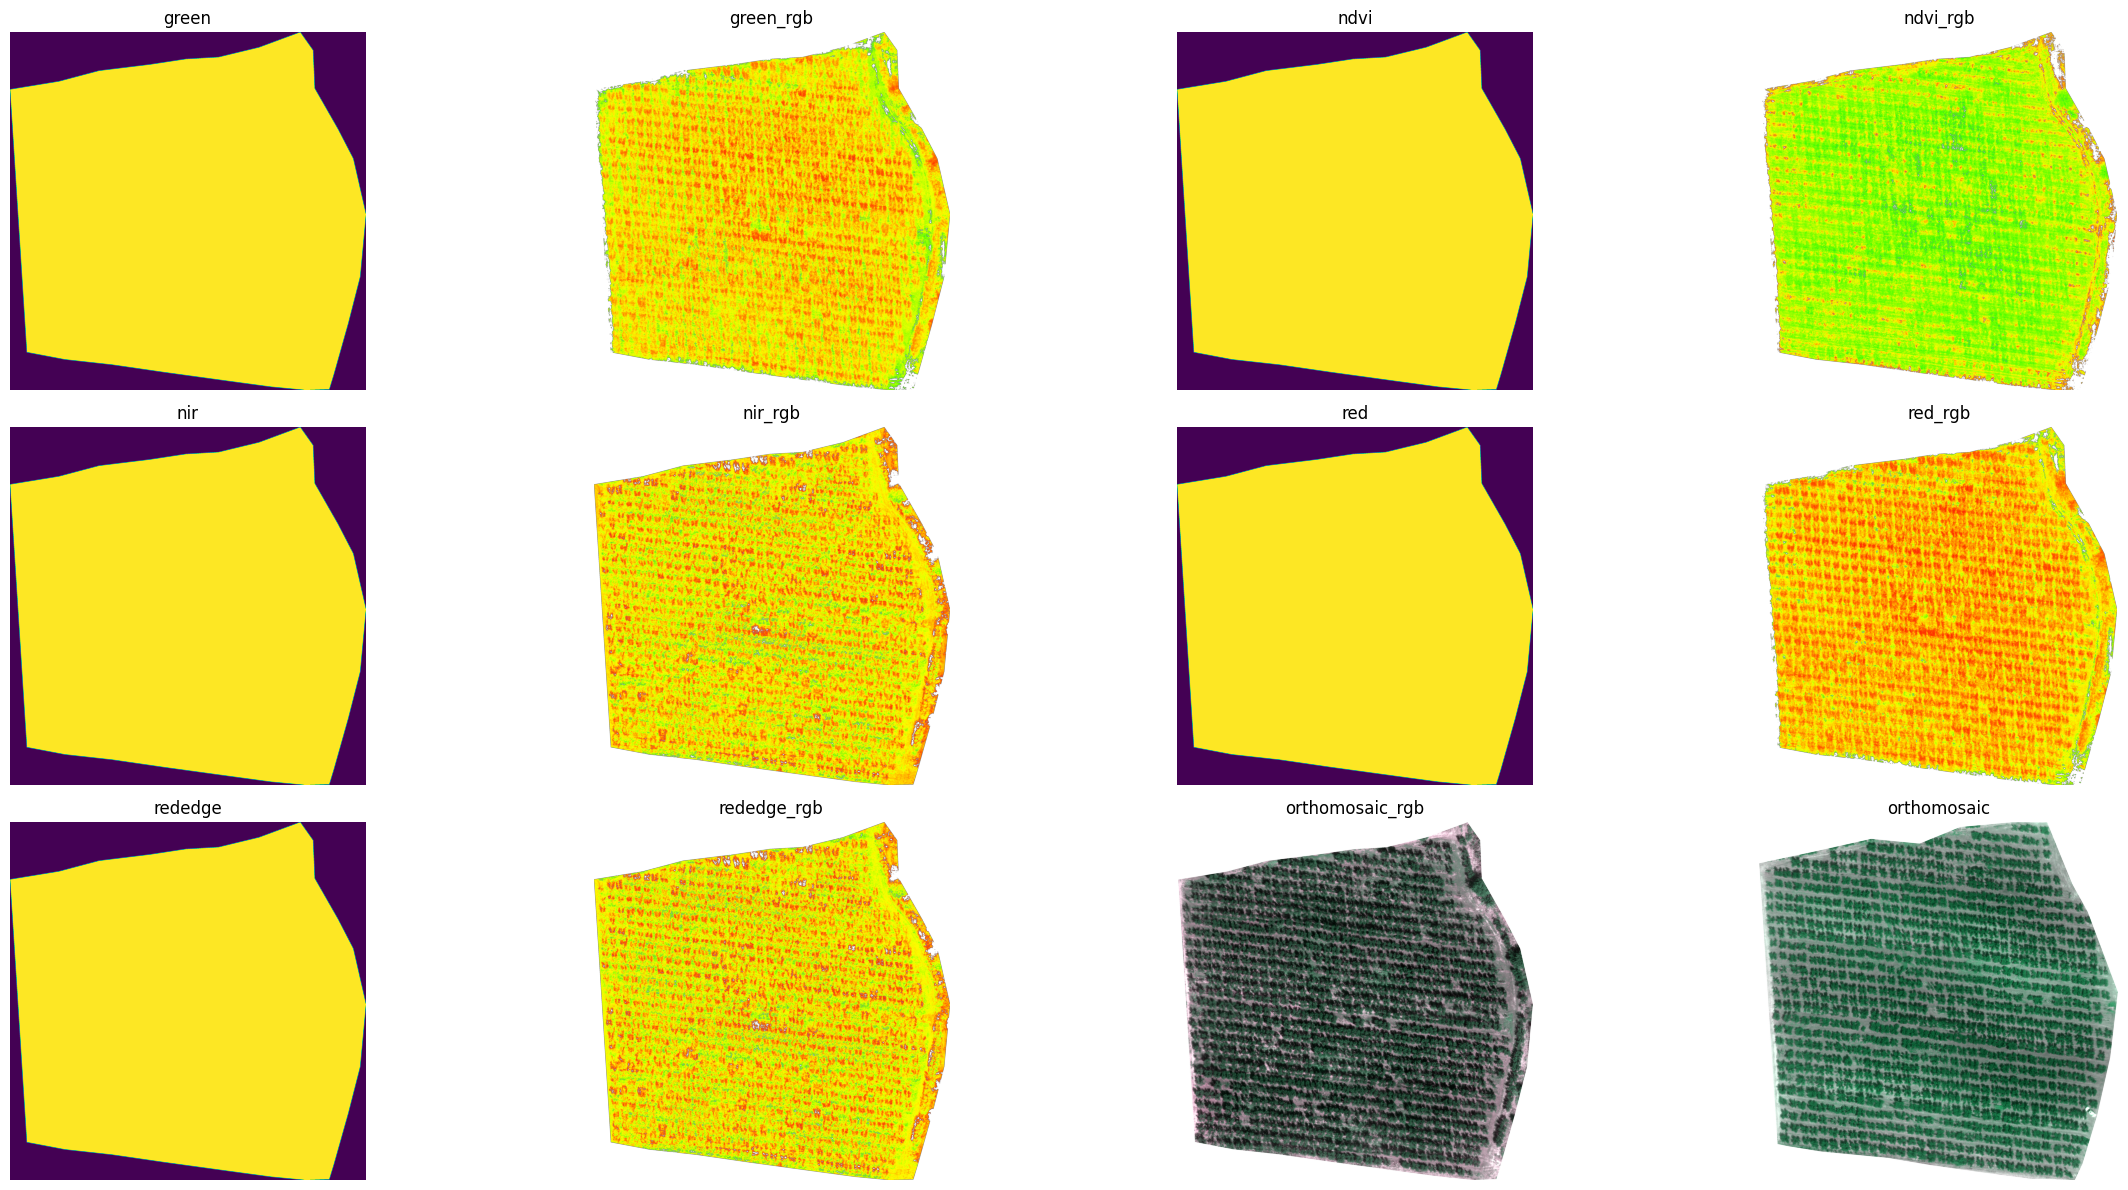

In [55]:
# Display the converted images
fig, axes = plt.subplots(3, 4, figsize=(25, 12))
axes = axes.flatten()

for ax, (name, image) in zip(axes, converted_uav_images.items()):
    ax.imshow(image)
    ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [56]:
green_rgb_image = cv2.imread(uav_images_file_paths['orthomosaic'])
green_rgb_gray = cv2.cvtColor(green_rgb_image, cv2.COLOR_BGR2GRAY)

In [57]:
# Apply a binary threshold to the image
_, binary = cv2.threshold(green_rgb_gray, 200, 255, cv2.THRESH_BINARY_INV)

In [58]:
# Perform morphological operations to remove noise and separate individual trees
kernel = np.ones((5, 5), np.uint8)
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

In [59]:
# Find contours of the trees
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [60]:
# Count the number of contours which corresponds to the number of trees
number_of_trees = len(contours)

number_of_trees

1

In [66]:
# Create an image copy to draw the dots
green_rgb_image_with_dots = Image.open(uav_images_file_paths['orthomosaic'])
draw_dots = ImageDraw.Draw(green_rgb_image_with_dots)

In [92]:
# Function to plot the tree positions on the image
def plot_tree_positions_on_image(status_grid, image, title):
    image_np = np.asarray(image)  # Convert image to numpy array
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image_np)
    
    num_rows, num_cols = status_grid.shape
    img_height, img_width, _ = image_np.shape
    cell_height = img_height / num_rows
    cell_width = img_width / num_cols
    
    for i in range(num_rows):
        for j in range(num_cols):
            status = status_grid[i, j]
            if not np.isnan(status):
                color = status_colors.get(int(status), 'gray')
                # Calculate the center of the cell
                center_x = j * cell_width + cell_width / 2
                center_y = i * cell_height + cell_height / 2
                circle = plt.Circle((center_x, center_y), min(cell_width, cell_height) / 4, color=color, edgecolor='black')
                ax.add_patch(circle)
    
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_height, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.show()

TypeError: Image data of dtype <U111 cannot be converted to float

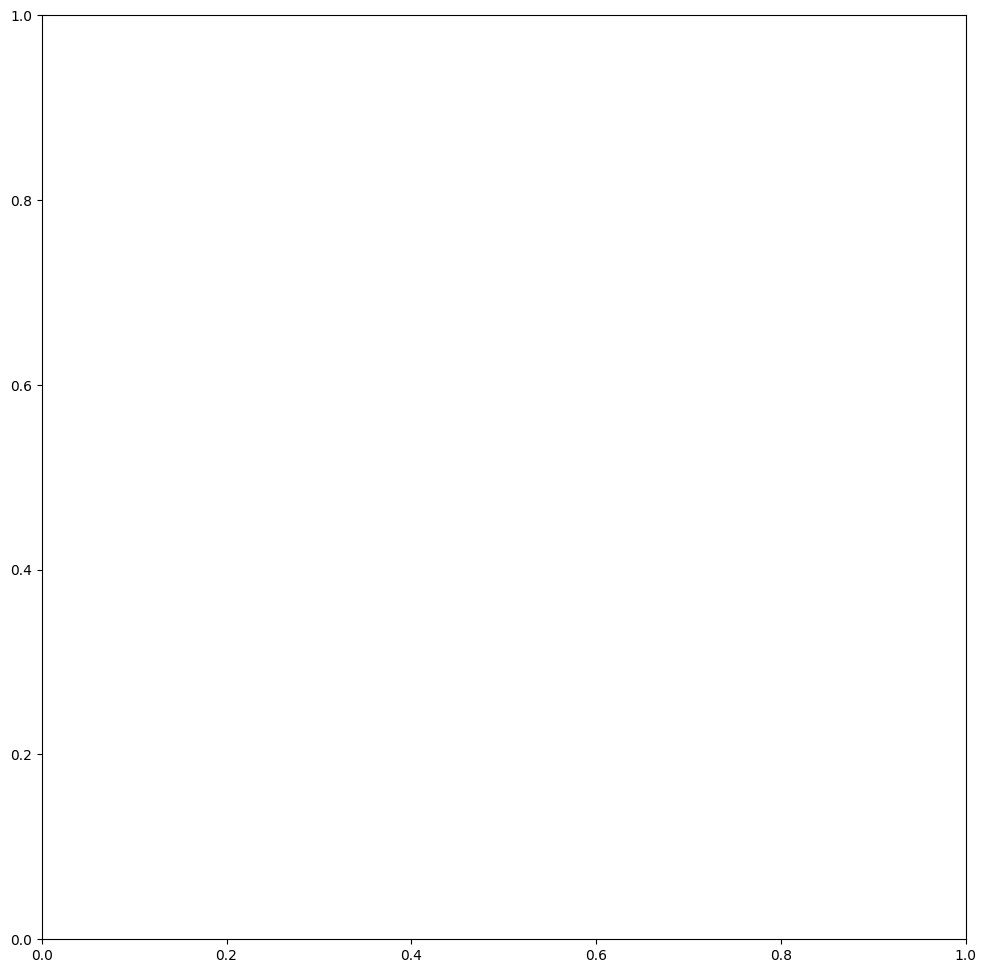

In [93]:
# Assuming status_grid is already created and available
ndvi_image = uav_images_file_paths["orthomosaic"]
plot_tree_positions_on_image(status_grid, ndvi_image, "Tree Positions on NDVI Image")

In [121]:
# Load the newly uploaded orthomosaic image
new_orthomosaic_image_path = '/Users/izzymohamed/Desktop/Vision For Social Good/Exclude/DATA/Peach/Orthomosaic.tif'
new_orthomosaic_image = Image.open(new_orthomosaic_image_path).convert("RGB")
new_orthomosaic_array = np.array(new_orthomosaic_image)

# Display the image
# Convert PIL image to OpenCV format
image_cv = cv2.cvtColor(np.array(new_orthomosaic_image), cv2.COLOR_RGB2BGR)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)

# Use HoughCircles to detect circles in the image
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=1, param1=50, param2=30, minRadius=5, maxRadius=20)

# If circles are detected, convert the (x, y, r) values to integers
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")

# Count the number of circles detected
num_circles = circles.shape[0] if circles is not None else 0

num_circles

5947

### Step 7: Compute the NDVI Image

In [ ]:
# Load the images
red_path = os.path.join(base_dir, "04_11_21", "Aerial_UAV_Photos", "red.data.tif") # "/mnt/data/red.tif"
nir_path = os.path.join(base_dir, "04_11_21", "Aerial_UAV_Photos", "nir.data.tif") # "/mnt/data/nir.tif"
rededge_path = os.path.join(base_dir, "04_11_21", "Aerial_UAV_Photos", "rededge.data.tif") # "/mnt/data/rededge.tif"

In [ ]:
# Open the images using PIL
red = Image.open(red_path)
nir = Image.open(nir_path)
rededge = Image.open(rededge_path)

In [ ]:
# Convert the images to numpy arrays
nir = np.asarray(nir)
red = np.asarray(red)
rededge = np.asarray(rededge)

In [ ]:
# Compute NDVI
ndvi = (nir - red) / (nir + red)

In [ ]:
# Apply color mapping for visualization
def apply_color_map(ndvi):
    colormap = np.zeros((ndvi.shape[0], ndvi.shape[1], 3), dtype=np.uint8)
    colormap[ndvi <= 0] = [0, 0, 0]
    colormap[(ndvi > 0) & (ndvi < 0.06)] = [255, 0, 0]
    colormap[(ndvi >= 0.06) & (ndvi < 0.12)] = [255, 32, 0]
    colormap[(ndvi >= 0.12) & (ndvi < 0.18)] = [255, 64, 0]
    colormap[(ndvi >= 0.18) & (ndvi < 0.24)] = [255, 96, 0]
    colormap[(ndvi >= 0.24) & (ndvi < 0.30)] = [255, 128, 0]
    colormap[(ndvi >= 0.30) & (ndvi < 0.36)] = [255, 160, 0]
    colormap[(ndvi >= 0.36) & (ndvi < 0.42)] = [255, 192, 0]
    colormap[(ndvi >= 0.42) & (ndvi < 0.48)] = [255, 224, 0]
    colormap[(ndvi >= 0.48) & (ndvi < 0.54)] = [255, 240, 0]
    colormap[(ndvi >= 0.54) & (ndvi < 0.60)] = [224, 255, 0]
    colormap[(ndvi >= 0.60) & (ndvi < 0.66)] = [192, 255, 0]
    colormap[(ndvi >= 0.66) & (ndvi < 0.72)] = [176, 255, 0]
    colormap[(ndvi >= 0.72) & (ndvi < 0.78)] = [160, 255, 0]
    colormap[(ndvi >= 0.78) & (ndvi < 0.84)] = [144, 255, 0]
    colormap[(ndvi >= 0.84) & (ndvi < 0.90)] = [64, 255, 0]
    colormap[ndvi >= 0.90] = [16, 255, 0]
    return colormap

In [ ]:
# Apply the color map
colored_ndvi = apply_color_map(ndvi)
ndvi_image = Image.fromarray(colored_ndvi)

# Save the NDVI image
ndvi_image.save(os.path.join(base_dir, "04_11_21", "Aerial_UAV_Photos", "NDVI_RGB.png"))

In [ ]:
# Assuming multimodal_df is already created and available
ndvi_values = []

for index, row in multimodal_df.iterrows():
    # Get the normalized center and radius coordinates
    norm_center_x = row['Norm_Center_X']
    norm_center_y = row['Norm_Center_Y']
    norm_radius_x = row['Norm_Radius_X']
    norm_radius_y = row['Norm_Radius_Y']
    
    # Convert to pixel coordinates and clamp to valid range
    center_x = min(max(int(norm_center_x * ndvi.shape[1]), 0), ndvi.shape[1] - 1)
    center_y = min(max(int(norm_center_y * ndvi.shape[0]), 0), ndvi.shape[0] - 1)
    
    # Get the NDVI value at the center coordinates
    ndvi_value = ndvi[center_y, center_x]
    ndvi_values.append(ndvi_value)

In [ ]:
# Add NDVI values to the DataFrame
multimodal_df['NDVI'] = ndvi_values

In [ ]:
# Save the DataFrame with NDVI values
output_csv_path = os.path.join(base_dir, "04_11_21", "multimodal_data.csv")
multimodal_df.to_csv(output_csv_path, index=False)